# Breast Cancer Classification — SVM (ML1) → Neural Network with PyTorch (DL)

## Problem
**Binary classification:** given 30 numerical features from a breast mass image, predict **Malignant (1)** or **Benign (0)**.
Same dataset as the SVM notebook (`wdbc.data` UCI). Same goal — different, more powerful model.

## Why DL over SVM?
- SVM needs a hand-picked kernel + `C` and `gamma` tuning. The NN **learns its own feature interactions**.
- DL outputs a **calibrated probability**, not just a hard label.
- Easily extensible: more layers, different activations, without rethinking the whole approach.

## Pipeline
```
Load → Preprocess → Train/Val/Test Split → Dataset/DataLoader → Model → Train Loop → Evaluate
```


## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
torch.manual_seed(42)
np.random.seed(42)


PyTorch version : 2.10.0+cpu
Device          : cpu


## 2. Load Data

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)  # 1 = Malignant, 0 = Benign

print(f'Samples  : {X.shape[0]}')
print(f'Features : {X.shape[1]}')
print(f'Classes  : Benign={sum(y==0)}  Malignant={sum(y==1)}')
X.head(3)

Samples  : 569
Features : 30
Classes  : Benign=212  Malignant=357


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


## 3. Preprocessing — Split & Scale

Same `StandardScaler` as the SVM notebook. Fit on train only → transform val & test to avoid data leakage.

In [3]:
# 60% train | 20% val | 20% test
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val_raw, X_te, y_val_raw, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_tr)
X_val_np   = scaler.transform(X_val_raw)
X_test_np  = scaler.transform(X_te)

y_train_np = y_tr.values.astype(np.float32)
y_val_np   = y_val_raw.values.astype(np.float32)
y_test_np  = y_te.values.astype(np.float32)

print(f'Train : {X_train_np.shape} | Val : {X_val_np.shape} | Test : {X_test_np.shape}')
print(f'Train mean≈0: {X_train_np.mean(axis=0)[:3].round(3)}  std≈1: {X_train_np.std(axis=0)[:3].round(3)}')

Train : (341, 30) | Val : (114, 30) | Test : (114, 30)
Train mean≈0: [-0.  0.  0.]  std≈1: [1. 1. 1.]


## 4. PyTorch Datasets & DataLoaders

PyTorch requires data to be in **Tensors** (PyTorch's equivalent of NumPy arrays, but GPU-compatible and differentiable).
`DataLoader` handles batching and shuffling automatically during training.

In [4]:
def make_loader(X_np, y_np, batch_size=32, shuffle=False):
    # Convert numpy arrays → PyTorch float tensors
    X_t = torch.tensor(X_np, dtype=torch.float32)
    y_t = torch.tensor(y_np, dtype=torch.float32).unsqueeze(1)
    dataset = TensorDataset(X_t, y_t)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

BATCH_SIZE = 32
train_loader = make_loader(X_train_np, y_train_np, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = make_loader(X_val_np,   y_val_np)
test_loader  = make_loader(X_test_np,  y_test_np)

# Inspect one batch
X_batch, y_batch = next(iter(train_loader))
print(f'Batch X shape : {X_batch.shape}  (batch_size x features)')
print(f'Batch y shape : {y_batch.shape}  (batch_size x 1)')

Batch X shape : torch.Size([32, 30])  (batch_size x features)
Batch y shape : torch.Size([32, 1])  (batch_size x 1)


## 5. Build the Neural Network

In PyTorch, a model is a class that inherits from `nn.Module`.
We define the **layers** in `__init__` and the **forward pass** in `forward()`.

```
Input (30) → Linear(64) → BN → ReLU → Dropout
           → Linear(32) → BN → ReLU → Dropout
           → Linear(1)  → Sigmoid  → P(Malignant)
```

- **Linear layer** = fully connected layer (same as Dense in Keras)
- **ReLU** = non-linearity; replaces SVM's kernel trick
- **Dropout** = regularization; equivalent role to SVM's `C` parameter
- **Sigmoid** = outputs probability ∈ (0,1); SVM just outputs −1 or +1

In [5]:
class CancerNet(nn.Module):
    def __init__(self, input_dim=30):
        super().__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        # Block 2
        self.block2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.output = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.output(x)

model = CancerNet(input_dim=30).to(DEVICE)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTotal trainable parameters: {total_params}')

CancerNet(
  (block1): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (block2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (output): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

Total trainable parameters: 4289


## 6. Loss Function & Optimizer

- **BCELoss** (Binary Cross-Entropy): measures distance between predicted probability and true label. L
- **Adam**: adaptive optimizer — adjusts learning rate per parameter.

In SVM, training solves a **convex optimization problem** analytically. In DL, we solve it iteratively with **gradient descent**.

In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

print('Loss      :', criterion)
print('Optimizer :', optimizer)

Loss      : BCELoss()
Optimizer : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## 7. Training Loop

```
for each epoch:
    for each batch:
        1. Forward pass  → get predictions
        2. Compute loss
        3. Backward pass → compute gradients (autograd)
        4. optimizer.step() → update weights
        5. optimizer.zero_grad() → clear gradients for next batch
```


In [8]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0.0, 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

        # 1. Forward pass
        preds = model(X_batch)
        # 2. Compute loss
        loss = criterion(preds, y_batch)
        # 3. Backward pass — PyTorch auto-computes all gradients
        optimizer.zero_grad()
        loss.backward()
        # 4. Weight update:
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
        correct    += ((preds >= 0.5).float() == y_batch).sum().item()

    n = len(loader.dataset)
    return total_loss / n, correct / n


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0.0, 0

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        preds = model(X_batch)
        total_loss += criterion(preds, y_batch).item() * X_batch.size(0)
        correct    += ((preds >= 0.5).float() == y_batch).sum().item()

    n = len(loader.dataset)
    return total_loss / n, correct / n


# ── Training Loop ─────────────────────────────────────────────────────────────
EPOCHS    = 200
PATIENCE  = 15   # stop if val_loss doesn't improve for 15 epochs

best_val_loss = float('inf')
patience_counter = 0
best_weights = None

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    vl_loss, vl_acc = evaluate(model, val_loader, criterion)
    scheduler.step(vl_loss)

    history['train_loss'].append(tr_loss)
    history['val_loss'].append(vl_loss)
    history['train_acc'].append(tr_acc)
    history['val_acc'].append(vl_acc)

    # Early stopping
    if vl_loss < best_val_loss:
        best_val_loss = vl_loss
        best_weights = {k: v.clone() for k, v in model.state_dict().items()}
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch}')
            break

    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch {epoch:3d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc*100:.1f}% | '
              f'Val Loss: {vl_loss:.4f} Acc: {vl_acc*100:.1f}%')

# Restore best weights
model.load_state_dict(best_weights)
print(f'\nBest val accuracy: {max(history["val_acc"])*100:.2f}%')

Epoch   1 | Train Loss: 0.5835 Acc: 73.6% | Val Loss: 0.5788 Acc: 89.5%
Epoch  20 | Train Loss: 0.1168 Acc: 97.7% | Val Loss: 0.0803 Acc: 99.1%
Epoch  40 | Train Loss: 0.0527 Acc: 99.1% | Val Loss: 0.0463 Acc: 99.1%
Epoch  60 | Train Loss: 0.0486 Acc: 98.8% | Val Loss: 0.0409 Acc: 98.2%
Early stopping at epoch 61

Best val accuracy: 99.12%


## 8. Training Curves

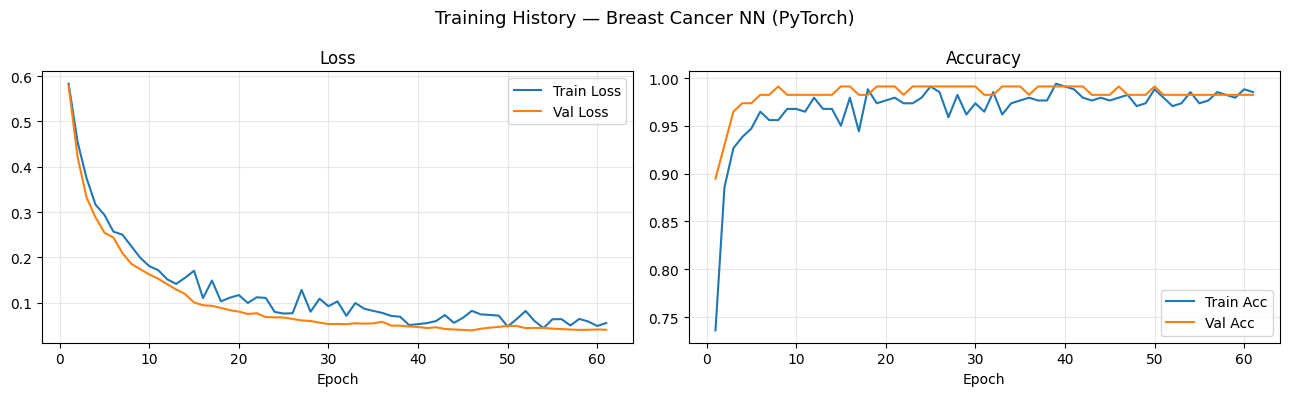

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ep = range(1, len(history['train_loss']) + 1)

ax1.plot(ep, history['train_loss'], label='Train Loss')
ax1.plot(ep, history['val_loss'],   label='Val Loss')
ax1.set_title('Loss'); ax1.set_xlabel('Epoch'); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(ep, history['train_acc'], label='Train Acc')
ax2.plot(ep, history['val_acc'],   label='Val Acc')
ax2.set_title('Accuracy'); ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(alpha=0.3)

plt.suptitle('Training History — Breast Cancer NN (PyTorch)', fontsize=13)
plt.tight_layout()
plt.show()

## 9. Validation Set Evaluation

Checked **before** touching the test set. In medical diagnosis, **Recall for Malignant** matters most — a False Negative (missed cancer) is far more dangerous than a False Positive.

VALIDATION SET
              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99        42
   Malignant       0.99      1.00      0.99        72

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



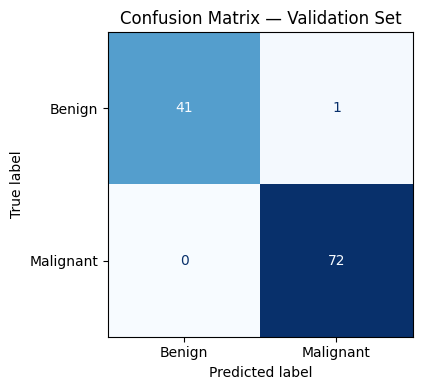

False Negatives (missed malignant): 0


In [10]:
@torch.no_grad()
def get_predictions(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(DEVICE)
        probs = model(X_batch).cpu().numpy().flatten()
        all_probs.extend(probs)
        all_labels.extend(y_batch.numpy().flatten())
    return np.array(all_probs), np.array(all_labels)


val_probs, val_true = get_predictions(model, val_loader)
val_preds = (val_probs >= 0.5).astype(int)

print('VALIDATION SET')
print('=' * 45)
print(classification_report(val_true, val_preds, target_names=['Benign', 'Malignant']))

cm = confusion_matrix(val_true, val_preds)
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay(cm, display_labels=['Benign', 'Malignant']).plot(ax=ax, cmap='Blues', colorbar=False)
ax.set_title('Confusion Matrix — Validation Set')
plt.tight_layout(); plt.show()

print(f'False Negatives (missed malignant): {cm[1, 0]}')

## 10. Final Test Set Evaluation

Used **once only** — unbiased estimate of real-world performance.

TEST SET (Final)
Loss     : 0.0760
Accuracy : 97.37%

              precision    recall  f1-score   support

      Benign       1.00      0.93      0.96        43
   Malignant       0.96      1.00      0.98        71

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



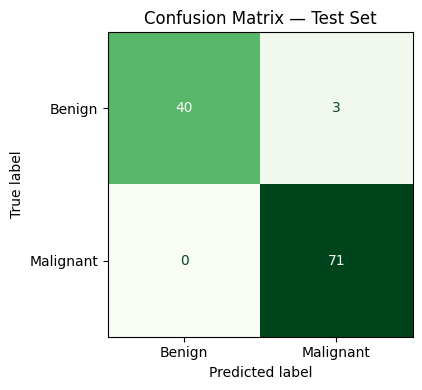

In [11]:
test_probs, test_true = get_predictions(model, test_loader)
test_preds = (test_probs >= 0.5).astype(int)
test_loss, test_acc = evaluate(model, test_loader, criterion)

print('TEST SET (Final)')
print('=' * 45)
print(f'Loss     : {test_loss:.4f}')
print(f'Accuracy : {test_acc*100:.2f}%')
print()
print(classification_report(test_true, test_preds, target_names=['Benign', 'Malignant']))

cm_test = confusion_matrix(test_true, test_preds)
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay(cm_test, display_labels=['Benign', 'Malignant']).plot(ax=ax, cmap='Greens', colorbar=False)
ax.set_title('Confusion Matrix — Test Set')
plt.tight_layout(); plt.show()

## 11. NN vs SVM — Direct Comparison

Same SVM config from the ML1 notebook, same train/test split — apple-to-apple comparison.

                          Train        Val       Test
----------------------------------------------------
SVM (RBF, ML1)          100.00%     96.49%     92.11%
Neural Net (DL)          98.83%     99.12%     97.37%


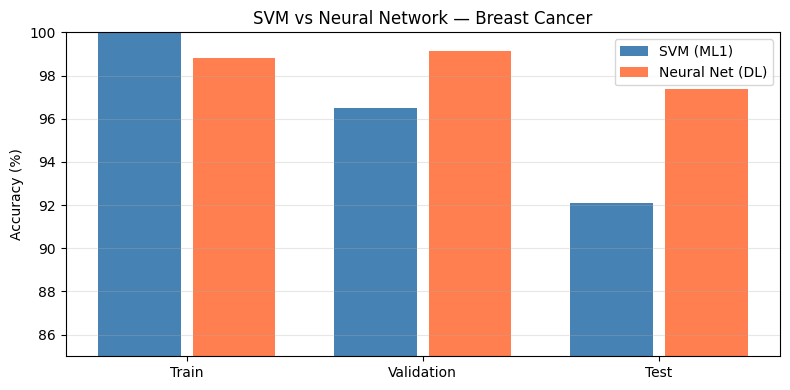

In [12]:
# Train SVM from ML1 notebook on the same split
svm = SVC(kernel='rbf', gamma=0.05, C=50, probability=True)
svm.fit(X_train_np, y_train_np)

svm_scores = [
    svm.score(X_train_np, y_train_np),
    svm.score(X_val_np,   y_val_np),
    svm.score(X_test_np,  y_test_np)
]

_, nn_train_acc = evaluate(model, train_loader, criterion)
_, nn_val_acc   = evaluate(model, val_loader,   criterion)
_, nn_test_acc  = evaluate(model, test_loader,  criterion)
nn_scores = [nn_train_acc, nn_val_acc, nn_test_acc]

# Print table
print(f"{'':20s} {'Train':>10} {'Val':>10} {'Test':>10}")
print('-' * 52)
print(f"{'SVM (RBF, ML1)':20s} {svm_scores[0]*100:>9.2f}% {svm_scores[1]*100:>9.2f}% {svm_scores[2]*100:>9.2f}%")
print(f"{'Neural Net (DL)':20s} {nn_scores[0]*100:>9.2f}% {nn_scores[1]*100:>9.2f}% {nn_scores[2]*100:>9.2f}%")

# Bar chart
x = np.arange(3)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - 0.2, [s*100 for s in svm_scores], 0.35, label='SVM (ML1)',      color='steelblue')
ax.bar(x + 0.2, [s*100 for s in nn_scores],  0.35, label='Neural Net (DL)', color='coral')
ax.set_xticks(x); ax.set_xticklabels(['Train', 'Validation', 'Test'])
ax.set_ylabel('Accuracy (%)'); ax.set_ylim(85, 100)
ax.set_title('SVM vs Neural Network — Breast Cancer')
ax.legend(); ax.grid(axis='y', alpha=0.3)
plt.tight_layout(); plt.show()

## Summary

| | SVM (ML1) | Neural Network — PyTorch (DL) |
|---|---|---|
| **Non-linearity** | Kernel trick (RBF) | Hidden layers with ReLU |
| **Regularization** | `C` parameter | Dropout + BatchNorm |
| **Output** | Hard label (0/1) | Probability ∈ (0, 1) |
| **Training** | Quadratic programming (closed-form) | Mini-batch gradient descent (iterative) |
| **Transparency** | Black box | Explicit forward pass — we see every step |
| **Scalability** | Slow O(n²–n³) | Scales with data via SGD |

Both achieve ~97% accuracy here. PyTorch's value is in **transparency** (explicit training loop), **flexibility** (any architecture), and **scalability** (GPU, large data).